In [1]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Chargement des données

In [2]:
batch_size = 128

# Appliquer des transformations si nécessaire (par exemple, conversion en tenseur)
transform = transforms.Compose([transforms.ToTensor()])

# Charger le jeu de données Fashion-MNIST
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


# Créer des DataLoaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

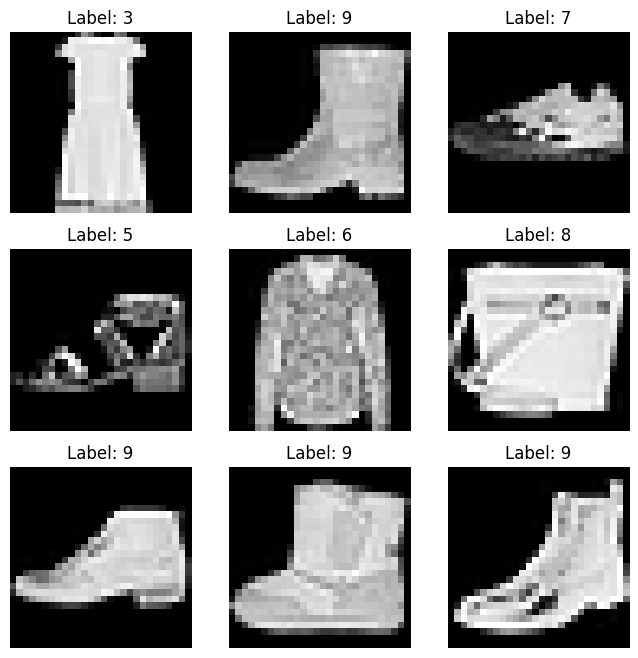

In [3]:
def plot_images(img_dataset):
    """Plots 9 random images from the given dataset

    Args:
        img_dataset (torch.utils.data.Dataset): The dataset to plot images from
    """
    # Set up a 3x3 grid for plotting 9 random images
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    
    # Plot 9 random images from the img_dataset
    for i in range(1, cols * rows + 1):
        random_idx = torch.randint(len(img_dataset), size=(1,)).item()  # Pick a random index
        img, label = img_dataset[random_idx]  # Get the image and its label
        figure.add_subplot(rows, cols, i)  # Add subplot
        plt.title(f'Label: {label}')  # Set title to show the label
        plt.axis("off")  # Turn off axis
        plt.imshow(img.squeeze(), cmap="gray")  # Plot image
    
    plt.show()  # Display the figure

plot_images(train_dataset)

In [4]:
train_dataset = train_dataset.data.view(-1, 28*28).float()
train_dataset = train_dataset / 255.0
test_dataset = test_dataset.data.view(-1, 28*28).float()
test_dataset = test_dataset / 255.0

In [24]:
def is_one_hot(one_hot_labels):
    # Vérifie la taille des vecteurs
    if one_hot_labels.ndim != 2:
        return False

    # Vérifie que chaque vecteur a la bonne taille
    num_samples, class_size = one_hot_labels.size()
    if class_size != one_hot_labels.size(1):
        return False

    # Vérifie que chaque vecteur contient exactement un '1'
    for label_vector in one_hot_labels:
        if label_vector.sum() != 1:
            return False

    return True

In [25]:
one_hot_labels = one_hot(labels, class_size=10)

# Vérification des labels one-hot
if is_one_hot(one_hot_labels):
    print("Les étiquettes sont bien one-hot encoded.")
else:
    print("Les étiquettes ne sont pas bien one-hot encoded.")

Les étiquettes sont bien one-hot encoded.


## 1. Define the VAE class
In this section we will define the VAE class that we will train and use for image generation. We make the choice of training a Convolutional VAE, with the following architecture (once more, we leave the number of hidden dimensions $p$ as a free parameter):
- **The Encoder:** The encoder will consist of the following layers:
    - Convolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 64 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 128 filters, a kernel size of 3, stride 2 and padding 1.
    - Batchnorm layer keeping the same number of features
    - ReLU layer

- **The Latent Space:** The encoder outputs are converted into the mean vector $\mu$ and logarithm of the variance vector $\log\sigma^2$, via two paraller fully connected layers. We will need to define:
    - A FC layer to map the output of the encoder $E(x)$ to the mean vector $\mu(x)$.
    - A FC layer to map the output of the encoder $E(x)$ to the log-variance vector $\log\sigma^2(x)$.
    - A FC layer to map the sampled hidden stacte $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ to the decoder input.

- **The Decoder.** The decoder will consist of the following layers:
    - Deconvolution layer with 64 filters, a kernel size of 3, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 1 filter, a kernel size of 4, stride 2 and padding 1.
    - Sigmoid layer

In [27]:
class ConvCVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(ConvCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4 + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4 + num_classes, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, labels):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4)  # Flatten the output of the convolutional layers

        # Concatenate the labels (one-hot encoded) with the encoder output
        x = torch.cat((x, labels), dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        # Concatenate the latent vector with the labels for decoding
        z = torch.cat((z, labels), dim=1)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.sample(mu, logvar)
        return self.decode(z, labels), mu, logvar

In [28]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

## 2. Define the loss function

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


## 3. Train the CVAE
In order to be able to visualize the latent space of the CVAE, we will choose a latent dimension equal to 2.

In [30]:
import torch
import torch.optim as optim

# Hyperparameters
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 10
beta = 1  # Regularization factor for the KL Divergence

# Initialize the CVAE model and the Adam optimizer
cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10)  # Notez l'ajout de num_classes
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Training loop
for epoch in range(1, epochs + 1):
    cvae.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize the cumulative loss for the current epoch

    # Iterate through the batches of training data
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)  # Move the input data to the GPU (if available)

        # Convert labels to one-hot encoding
        one_hot_labels = one_hot(labels, class_size=10).to(device)  # Assurez-vous que cela soit sur le bon device

        # Zero the gradients for this batch
        optimizer.zero_grad()

        # Forward pass through the model (passer les étiquettes aussi)
        recon_batch, mu, logvar = cvae(data, one_hot_labels)

        # Compute the loss for this batch
        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)

        # Backpropagate the loss and update model parameters
        loss.backward()
        optimizer.step()

        # Accumulate the batch loss
        running_loss += loss.item()

    # Compute and print the average loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')


Epoch 1, Training loss: 277.2427
Epoch 2, Training loss: 257.6997
Epoch 3, Training loss: 256.0396
Epoch 4, Training loss: 255.1884
Epoch 5, Training loss: 254.4606
Epoch 6, Training loss: 254.1563
Epoch 7, Training loss: 253.5567
Epoch 8, Training loss: 253.3003
Epoch 9, Training loss: 252.9702
Epoch 10, Training loss: 252.7518
Epoch 11, Training loss: 252.4123
Epoch 12, Training loss: 252.2521
Epoch 13, Training loss: 252.0757
Epoch 14, Training loss: 251.9076
Epoch 15, Training loss: 251.7632
Epoch 16, Training loss: 251.5702
Epoch 17, Training loss: 251.4631
Epoch 18, Training loss: 251.2995
Epoch 19, Training loss: 251.1916
Epoch 20, Training loss: 250.9589
Epoch 21, Training loss: 250.9326
Epoch 22, Training loss: 250.7718
Epoch 23, Training loss: 250.6439
Epoch 24, Training loss: 250.5873
Epoch 25, Training loss: 250.4698
Epoch 26, Training loss: 250.3773
Epoch 27, Training loss: 250.2568
Epoch 28, Training loss: 250.1019
Epoch 29, Training loss: 250.0641
Epoch 30, Training loss

## 4. Visualize the results
We first check if the vae model has learnt meaningful features, by plotting a bunch of images from the test set along with their respective reconstructions.

We have already define a function called `image_comparison` in the previous noteboo, that does exactly what we want. We can either copy paste it below, or better yet, create a file in the current folder called `utils.py`, copy-paste the function there, along with all the necessary library imports, and then import the `image_comparison` function in the cell below.

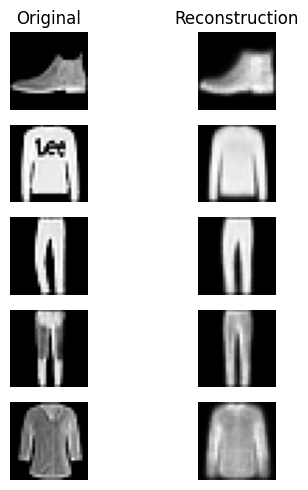

In [51]:
def image_comparison(original_images, reconstructions, n_images=5):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(n_images, 2, figsize=(5, 5))
    
    for i in range(n_images):
        # Plot original images
        ax[i, 0].imshow(original_images[i], cmap='gray')
        ax[i, 0].axis('off')
        ax[i, 0].set_xlabel("0")
        ax[0, 0].set_title('Original')

        # Reconstructed images
        ax[i, 1].imshow(reconstructions[i], cmap='gray')
        ax[i, 1].axis('off')
        ax[i, 1].set_xlabel("1")
        ax[0, 1].set_title('Reconstruction')
    
    plt.tight_layout()
    plt.show()

# Select a batch of images from the test dataset
random_images, labels = next(iter(test_loader))  # Extraire les labels aussi

# Convert labels to one-hot encoding
one_hot_labels = one_hot(labels, class_size=10).to(device)  # Assurez-vous que cela soit sur le bon device

# Get the reconstructions of the selected images
recons, _, _ = cvae(random_images.to(device), one_hot_labels)  # Passer les labels ici

# Reshape the images for plotting
random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)


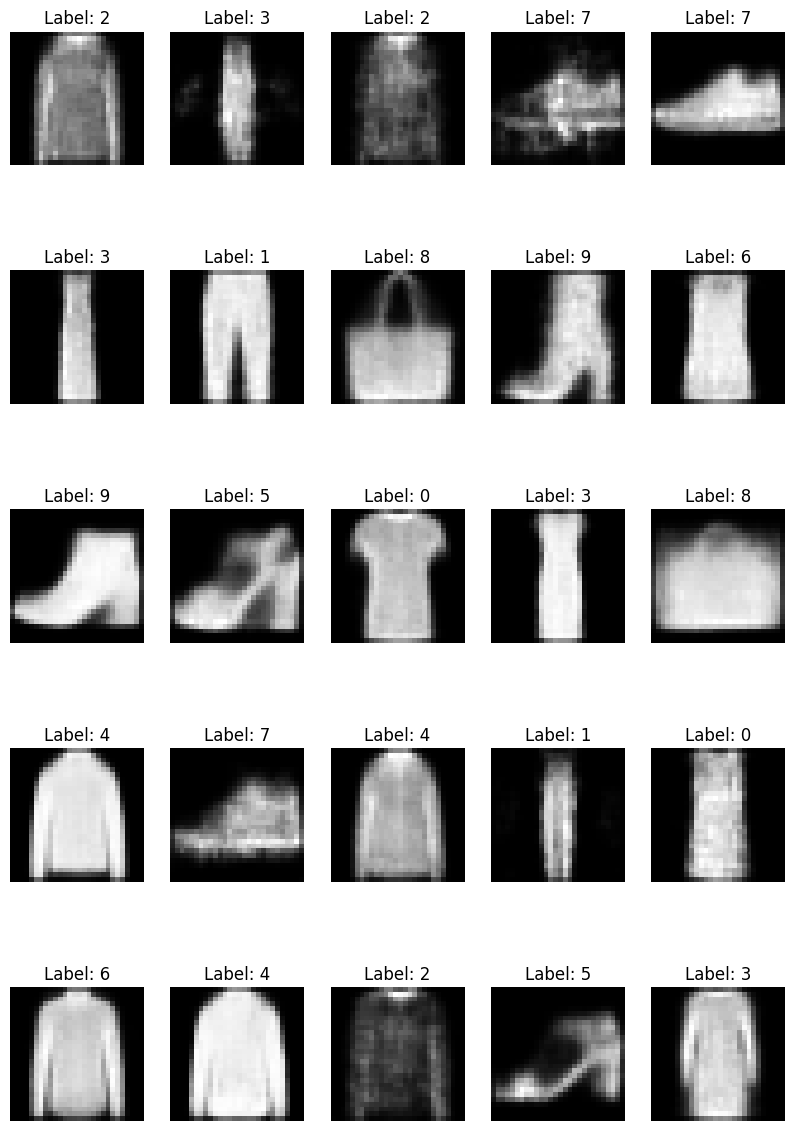

In [58]:
def generate_sample(num_samples=25):
    cvae.eval()
    with torch.no_grad():
        # Sample random labels for the generated samples
        labels = torch.randint(0, 10, (num_samples,)).to(device)  # Assuming 10 classes
        one_hot_labels = one_hot(labels, class_size=10).to(device)  # Convert to one-hot encoding
        
        # Generate latent vectors based on the labels
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample random latent vectors
        samples = cvae.decode(z, one_hot_labels)  # Decode the latent vectors conditioned on labels

        samples = samples.cpu().view(num_samples, 1, 28, 28)  # Reshape the samples
        
        # Create plots for original images and generated samples
        col = 5  # Number of classes
        row = int(num_samples / col)  # Number of new samples per class

        fig, ax = plt.subplots(col, row, figsize=(10, 15))
        
        # Plot generated samples in the grid
        for i in range(col):
            for j in range(row):
                ax[i, j].imshow(samples[i * row + j].squeeze(0), cmap='gray')
                ax[i, j].axis('off')
                ax[i, j].set_title(f'Label: {labels[i * row + j].item()}')

        plt.show()

generate_sample()


## 6. Interpolation between Images
The objective of this section is to visualize the difference between the space of latent representations and the (original) pixel space. In order to do so, we will perform *image interpolation*, i.e., we will take two random images $x_2$ and $x_2$ from the test set, and interpolate between them: for a given number of interpolation steps $n$, we have:
- In pixel space, the interpolated image $x_t$ at step $t=0,\dots,n$ is given by taking, for each pixel, the linear interpolation
$$\frac{n-t}{n}x_1 + \frac{t}{n}x_2.$$
- In the latent space, the interpolated image $x_t$ at step $t=0,\dots,n$ is given by first computing the linear interpolation $z_t$ between the encodings $z_1$ of $x_1$ and $z_2$ of $x_2$, and then decoding $z_t$.

In [59]:
# TODO: Implement the interpolate_pixel_space function
# the function should take two images as input and the numer of interpolation steps
# and plot the interpolated images in a single row

def interpolate_pixel_space(x1, x2, num_steps=10):
    # Ensure the images are on the same device and have the correct shape
    x1 = x1.view(1, 1, 28, 28).to(device)
    x2 = x2.view(1, 1, 28, 28).to(device)

    # Generate interpolation factors between 0 and 1
    t_values = torch.linspace(0, 1, num_steps).to(device).view(-1, 1, 1, 1)

    # Interpolate directly in pixel space
    interpolated_images = x1 * (1 - t_values) + x2 * t_values

    # Move the images to CPU for visualization
    interpolated_images = interpolated_images.cpu().squeeze(1)  # Remove channel dimension if necessary

    # Plot the interpolated images
    fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
    for i in range(num_steps):
        ax[i].imshow(interpolated_images[i].squeeze(0), cmap='gray')
        ax[i].axis('off')
    plt.show()

x1, x2 = test_dataset[3][0], test_dataset[2][0]
interpolate_pixel_space(x1, x2)

RuntimeError: shape '[1, 1, 28, 28]' is invalid for input of size 1

In [ ]:
# TODO: Implement the interpolate_latent_space function
# the function should take two images as input and the numer of interpolation steps
# and plot the interpolated images in a single row

def interpolate_latent_space(x1, x2, num_steps=10):
    vae.eval()
    with torch.no_grad():
        x1, x2 = x1.to(device), x2.to(device)
        mu1, logvar1 = vae.encode(x1.view(1, 1, 28, 28))
        mu2, logvar2 = vae.encode(x2.view(1, 1, 28, 28))

        z1 = vae.sample(mu1, logvar1)
        z2 = vae.sample(mu2, logvar2)

        z = torch.stack([z1 * (1 - t) + z2 * t for t in torch.linspace(0, 1, num_steps)])
        samples = vae.decode(z).cpu()
        samples = samples.view(num_steps, 1, 28, 28)

        fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
        for i in range(num_steps):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

x1, x2 = test_dataset[3][0], test_dataset[2][0]
interpolate_latent_space(x1, x2)

## 7. Visualizing the latent space
The objective of this section is to visualize the latent space and to see how it changes according to which term in the loss function we give more weight to.

In [60]:
# Rewrite loss function to return BCE and KLD separately as well
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

In [61]:
# Hyperparameters
latent_dims = 2
batch_size = 128
num_epochs = 10
learning_rate = 1e-3
kl_weights = [1, 10, 100]  # Different weights for the KL divergence term

# Training and plotting function
def train_and_plot(kl_weight):
    model = ConvVAE(latent_dims).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(data)
            loss, bce, kld = loss_function(x_recon, data, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()

        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')

    # Plot latent space
    plot_latent_space(model, kl_weight)

# Function to plot latent space
def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        mu, logvar = model.encode(data)
        z = mu  # For visualization, we use the mean
        z = z.cpu().numpy()
        labels = labels.numpy()

        plt.figure(figsize=(8,6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()

# Run training and plotting for different KL weights
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)



Training VAE with KL Weight = 1


NameError: name 'ConvVAE' is not defined

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data, labels = data.to(device), labels.to(device)
            labels = one_hot(labels, 10)
            recon_batch, mu, logvar = model(data, labels)
            test_loss += loss_function(recon_batch, data, mu, logvar).detach().cpu().numpy()
            if i == 0:
                n = min(data.size(0), 5)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(-1, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'reconstruction_' + str(f"{epoch:02}") + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)

In [ ]:
def one_hot(labels, class_size): #class_size correspond au label que l'on veut représenter
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)



class CVAE(nn.Module):
    def __init__(self, feature_size, class_size=10, latent_dim=10):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size
### garder les meme couches que pour le vae du tp c'est sans doute plus efficace (choix arbitraire, demander à chat)
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )  

    def encode(self, x, c): # Q(z|x, c)
        '''
        x: (bs, feature_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([x, c], 1) # (bs, feature_size+class_size)
        x = self.encoder(inputs)
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, c): # P(x|z, c)
        '''
        z: (bs, latent_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([z, c], 1) # (bs, latent_size+class_size)
        x = self.fc_decode(inputs)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.sample(mu, logvar)
        return self.decode(z, c), mu, logvar

# create a CVAE model
model = CVAE(28*28, 10).to(device)